# Feature Detection

Kevin J. Walchko
created 17 Aug 2017

---

Feature detection uses various methods to find unique regions within an image. These features can then be used in tracking, stereo vision, image stitching, etc. High frequency locations like corners (think edge detection) are typically good candidates for features. This lesson will start off talking about features and move on to matching and homography. We will use homography  in camera calibration and show an example of a virtual billboard (like in baseball or soccer).

## Objectives

- understand different types of feature detection
- understand feature matching
- understand how homography works and applications

## References

- [Official OpenCV feature detector tutorials](http://docs.opencv.org/3.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html)
- [Learn OpenCV homography](https://www.learnopencv.com/homography-examples-using-opencv-python-c/)

## Setup

In [3]:
%matplotlib inline 

from __future__ import print_function
from __future__ import division
import cv2         # opencv itself
import numpy as np # matrix manipulations

from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

# What are Features

![](features.jpg)

The image is very simple. At the top of image, six small image patches are given. Question for you is to find the exact location of these patches in the original image. How many correct results can you find?

- **A and B:** are flat surfaces and they are spread over a lot of area. It is difficult to find the exact location of these patches.
- **C and D:** are much more simple. They are edges of the building. You can find an approximate location, but exact location is still difficult. This is because the pattern is same everywhere along the edge. At the edge, however, it is different. An edge is therefore better feature compared to flat area, but not good enough (It is good in jigsaw puzzle for comparing continuity of edges).
- **E and F:** are some corners of the building. And they can be easily found. Because at the corners, wherever you move this patch, it will look different. So they can be considered as good features. So now we move into simpler (and widely used image) for better understanding.

# Feature Detection

Features are image locations that are "easy" to find in an image.  Indeed, one of the early feature detection techniques Lucas-Kanade, sometimes called Kanade-Lucas-Tomasi or KLT features come from a seminal paper called "Good features to track". I point this out, because there is an OpenCV function called `cv2.goodFeaturesToTrack()` which does this!

Edge detection finds brightness discontinuities in an image while feature detection finds distinctive regions. There are a bunch of different feature detectors and these all have some characteristics in common: they should be quick and things that are close in image-space are close in feature-space (that is, the feature representation of an object looks like the feature representation of objects that look like that object).

Some of the available feature detectors available in OpenCV 3.3:

- **Harris Corner Detector:** Finds corners in images
- **SIFT (Scale-Invarient Feature Transform):** Harris corner detector is not good enough when scale of image changes. Lowe developed a breakthrough method to find scale-invariant features and it is called SIFT
- **SURF (Speeded-Up Robust Features):** SIFT is really good, but not fast enough, so people came up with a faster version called SURF.
- **FAST:** All the above feature detection methods are good in some way. But they are not fast enough to work in real-time applications like simultanious localization and mapping (SLAM)
- **BRIEF (Binary Robust Independent Elementary Features):** SIFT uses a feature descriptor with 128 floating point numbers. Consider thousands of such features. It takes lots of memory and more time for matching. We can compress it to make it faster. But still we have to calculate it first. There comes BRIEF which gives the shortcut to find binary descriptors with less memory, faster matching, still higher recognition rate
- **ORB (Oriented FAST and Robust BRIEF):** SIFT and SURF are good in what they do, but what if you have to pay a few dollars every year to use them in your applications? Yeah, they are patented!!! To solve that problem, OpenCV developers came up with a new "FREE" alternative to SIFT & SURF, and that is ORB.

**Note:** some of the very famous feature detectors (SIFT/SURF and so on) are available, but aren't in OpenCV by default due to patent issues. You can build them for OpenCV if you want, or you can find other implementations (David Lowe's SIFT implementation works just fine). Just google for instructions. For the purposes of this lesson (and to save time) we're only going to look at those which are in OpenCV by default.

## Corner detectors

If you think of edges as being lines, then corners are an obvious choice for features as they represent the intersection of two lines. One of the earlier corner detectors was introduced by Harris, and it is still a very effective corner detector that gets used quite a lot: it's reliable and it's fast. 

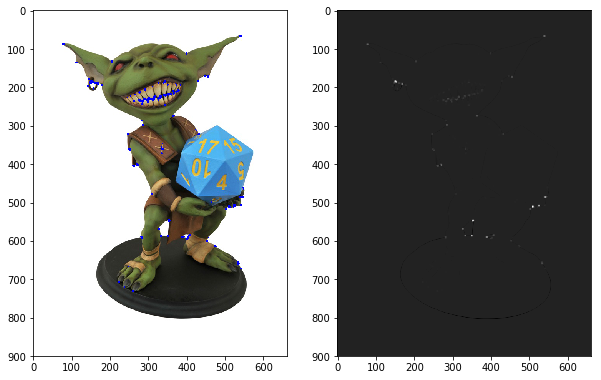

In [4]:
input_image = cv2.imread('dnd.jpg')
input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)
harris_test=input_image.copy()
# greyscale it
gray = cv2.cvtColor(harris_test,cv2.COLOR_RGB2GRAY)

gray = np.float32(gray)
blocksize=4 # 
kernel_size=3 # sobel kernel: must be odd and fairly small

# run the harris corner detector
# parameters are blocksize, Sobel parameter and Harris threshold
dst = cv2.cornerHarris(gray,blocksize,kernel_size,0.05) 

# result is dilated for marking the corners, this is
# visualisation related and just makes them bigger
dst = cv2.dilate(dst,None)

# we then plot these on the input image for visualisation 
# purposes, using bright red
harris_test[dst>0.01*dst.max()]=[0,0,255]

plt.subplot(1,2,1)
plt.imshow(harris_test);

plt.subplot(1,2,2)
plt.imshow(dst,cmap = 'gray');

Properly speaking the Harris Corner detection is more like a Sobel operator - indeed it is very much like a sobel operator. It doesn't really return a set of features, instead it is a filter which gives a strong response on corner-like regions of the image. We can see this more clearly if we look at the Harris output from the cell above (dst is the Harris response, before thresholding). Well we can kind-of see. You should be able to see that there are slightly light places in the image where there are corner like features, and that there are really light parts of the image around the black and white corners of the writing 

## Moving towards feature space

When we consider modern feature detectors there are a few things we need to mention. What makes a good feature includes the following: 

* Repeatability (got to be able to find it again)
* Distinctiveness/informativeness (features representing different things need to be different)
* Locality (they need to be local to the image feature and not, like, the whole image)
* Quantity (you need to be able to find enough of them for them to be properly useful)
* Accuracy (they need to accurately locate the image feature)
* Efficiency (they've got to be computable in reasonable time)

number key points found: 500
point: (537.0, 508.0) size: 31.0 angle: 51.8054695129


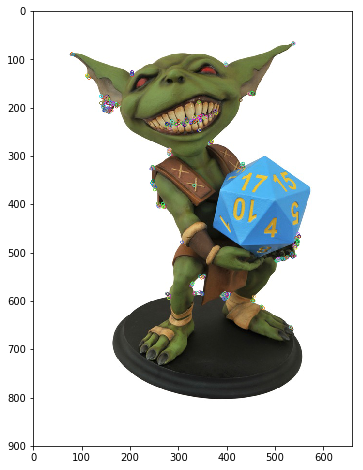

In [5]:
# make a copy to play with
orbimg=input_image.copy()

orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(orbimg,None)
# compute the descriptors with ORB
kp, des = orb.compute(orbimg, kp)
# draw keypoints
print('number key points found:', len(kp))
print('point: {} size: {} angle: {}'.format(kp[1].pt, kp[1].size, kp[1].angle))
cv2.drawKeypoints(orbimg,kp,orbimg)

plt.imshow(orbimg);

## Matching features
Finding features is one thing but actually we want to use them for matching. 
First let's get something where we know there's going to be a match

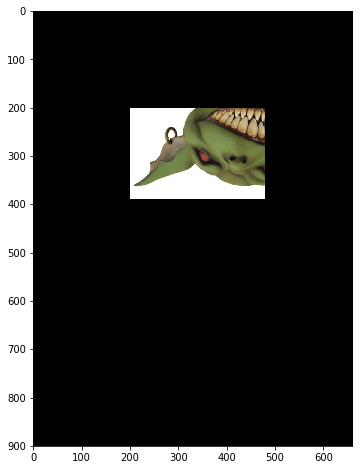

In [6]:
# create an image with all zeros (black), use the input image as a template for
# size and the color depth (3 for color)
img2match=np.zeros(input_image.shape,np.uint8)

# grab the goblin's face
face=input_image[60:250, 70:350] # copy out a bit
img2match[60:250,70:350]=[0,0,0] # blank that region
face=cv2.flip(face,0) # flip the copy
img2match[200:200+face.shape[0], 200:200+face.shape[1]]=face # paste it back somewhere else
plt.imshow(img2match);

## Matching keypoints

The feature matching function (in this case Orb) detects and then computes keypoint descriptors. These are a higher dimensional representation of the image region immediately around a point of interest (sometimes literally called "interest points"). 

These higher-dimensional representations can then be matched; the strength you gain from matching these descriptors rather than image regions directly is that they have a certain invariance to transformations (like rotation, or scaling). OpenCV providers matcher routines to do this, in which you can specify the distance measure to use.

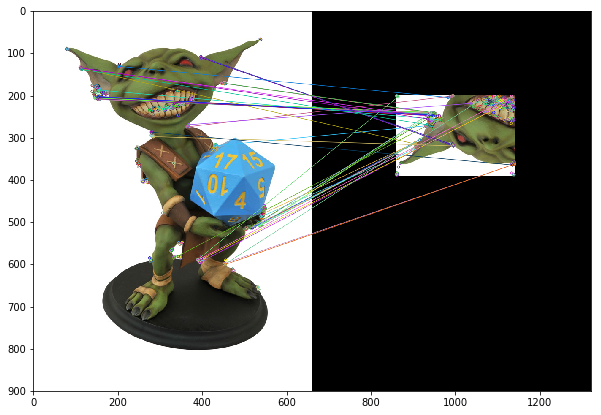

In [7]:
kp2 = orb.detect(img2match,None)
# compute the descriptors with ORB
kp2, des2 = orb.compute(img2match, kp2)
# create BFMatcher object: this is a Brute Force matching object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des,des2)
 
# Sort them by distance between matches in feature space - so the best matches are first.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 50 matches.
oimg = cv2.drawMatches(orbimg,kp,img2match,kp2,matches[:50], orbimg)
 
plt.imshow(oimg);

As you can see there are some false matches, but it's fairly clear that most of the matched keypoints found are actual matches between image regions on the face.

To be more precise about our matching we could choose to enforce **homography** constraints, which looks for features that sit on the same plane.

# Homography

A Homography is a transformation (a 3×3 matrix) that maps the points in one image to the corresponding points in the other image. 

![](image_stitching_1.jpg)

Since we are dealing with 2d images, we do:

$$
\begin{bmatrix}
  x_1 \\
  y_1 \\
  1
\end{bmatrix} =
H_{3x3}
\begin{bmatrix}
  x_2 \\
  y_2 \\
  1
\end{bmatrix} \\
H_{3x3} = \begin{bmatrix}
  Rotation_{2x2} & Translation_{(x,y)} \\
  skew & 1 
\end{bmatrix}
$$

Notice the 1 at the bottom, hopefully this reminds of homogenious transforms back in block 1, forward kinematics, but in 2d instead of 3d.

Homography has many uses:

#### Image Stitching

By matching features between 2 images, we can understand the relationship between the images and warp them in such a way, we can join the images together and make a larger panoramic view.

![](image_stitching_2.jpg)

#### Virtual Reality

Just like our little goblin above, we understand the points on the QR code and where the are in real space. If we match those point in the image, we can estimate the orientation of the camera relative to the QR code. Once we have that `pose` (remember that term from earlier?), we can draw a 3D object onto our 2D image and give it the correct orientation and lighting.

![](virtual-reality.jpg)

#### Camera Calibration

Just like above with the VR examples, we can match a target pattern in an image to real world coordinates and estimate the distortion that must occur. Later we will talk about camera calibration and how to do this.

![](calibration.jpg)

#### Perspective Correction

We don't always get the orientation we want in an image. That's okay, because in various applications we can warp (or reorient) the image perspective so we can get what we want. You see stuff like this in the movies all the time and some of it is real.

![](perspective-correction.jpg)

## Homography and OpenCV

To calculate a homography between two images, you need to know at least 4 point correspondences between the two images. If you have more than 4 corresponding points, it is even better. OpenCV will robustly estimate a homography that best fits all corresponding points. Usually, these point correspondences are found automatically by matching features like with SIFT or SURF between the images.

```python
'''
pts_src and pts_dst are numpy arrays of points
in source and destination images. We need at least 
4 corresponding points. 
'''
h, status = cv2.findHomography(pts_src, pts_dst)
 
''' 
The calculated homography can be used to warp 
the source image to destination. Size is the 
size (width,height) of im_dst
'''
 
im_dst = cv2.warpPerspective(im_src, h, size)
```

## Virtual Billboards

In many televised sports events, advertisements are virtually inserted into live video feeds. For example, both soccer and baseball place ads on small advertisement boards right outside the boundary of the field that can be virtually changed. Instead of displaying the same ad to everybody, advertisers can choose which ads to show based on the person’s demographics, location etc. In these applications the four corners of the advertisement board are detected in the video which serve as the destination points. The four corners of the ad serve as the source points. A homography is calculated based on these four corresponding points and it is used to warp the ad into the video frame.

advert size: (403L, 574L, 3L)
Homography matrix: [[  4.27796377e-01  -2.48138958e-01   1.00000000e+02]
 [  4.27796377e-01   2.35757002e-02   1.00000000e+02]
 [  1.26790175e-03  -1.12281629e-03   1.00000000e+00]]


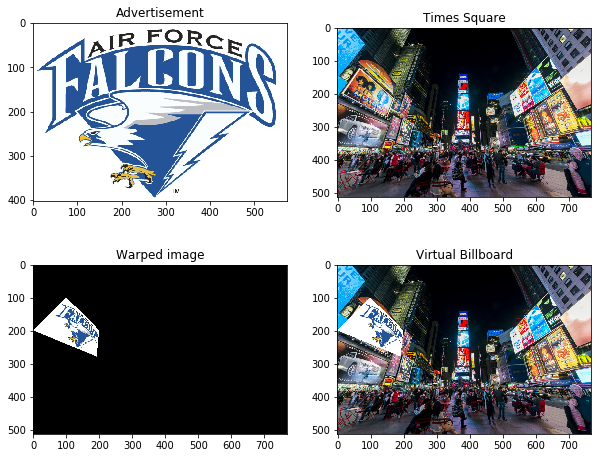

In [7]:
advert = cv2.imread('afa.jpg')
advert = cv2.cvtColor(advert,cv2.COLOR_BGR2RGB)

print('advert size:', advert.shape)

ts = cv2.imread('times-square.jpg')
ts = cv2.cvtColor(ts,cv2.COLOR_BGR2RGB)

# original image dimensions
pts_src = np.array([
    [0, 0],
    [0, advert.shape[0]],
    [advert.shape[0], advert.shape[1]],
    [advert.shape[1], 0]
])

# destination to map too
# note: I just eye balled this ... not perfect!
pts_dst = np.array([
    [100, 100],
    [0, 200],
    [150, 330],
    [200, 200]
])

h, status = cv2.findHomography(pts_src, pts_dst)

print('Homography matrix:', h)

# warp advert image
im_dst = cv2.warpPerspective(advert, h, (ts.shape[1], ts.shape[0]))

# this section of code will create a mask, then replace the masked 
# area with our advert:
# 1. convert copy to grayscale
# 2. threshold image so it is just black and white (binary)
# 3. invert mask (black)
# 4. cut out existing current colors there, anything and'ed with 0 is 0
# 5. now add the two images together and fill in the cut out
img2gray = cv2.cvtColor(im_dst,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
img1_bg = cv2.bitwise_and(ts,ts,mask = mask_inv)
final = img1_bg + im_dst

plt.subplot(2,2,1)
plt.imshow(advert)
plt.title('Advertisement')

plt.subplot(2,2,2)
plt.imshow(ts)
plt.title('Times Square')

plt.subplot(2,2,3)
plt.imshow(im_dst)
plt.title('Warped image')

plt.subplot(2,2,4)
plt.imshow(final)
plt.title('Virtual Billboard');

# Omni Cameras

![](lense.jpg)

Since we are talking about homography and warping images, I thought I would throw this in here about omni cameras. There is more than one way to create a camera that can see 360 degrees.

A catadioptric sensor is a camera made up of a mirror (catoptrics) and lenses (dioptrics). By simplifying things a lot, one can think of a catadioptric sensor as consisting of a normal camera viewing the world reflected in a parabolic-shaped mirror. To be useful, the mirror must be perfectly aligned with and placed at a precise distace from the camera. The main advantage of a catadioptric sensor is its panoramic view of the world, being able to view a full hemisphere (360 degrees by 90 degrees).

<img src="robot.jpg" width="300px">

Now for robotics, this offers a potential oppertunity for a sensor with 360$^\circ$ FOV. There are also examples of this process being done in stereo.

![](vo.gif)

## Dewarping

![](math.jpg)

In [8]:
class Dewarper:
    def __init__(self, Ws, Hs, Rmax, Rmin, Cx, Cy, interpolation=cv2.INTER_CUBIC):
        self.interpolation = interpolation

        # determine the destination image size
        Wd = int(2.0*(float(Rmax+Rmin)/2.0)*np.pi)
        Hd = Rmax-Rmin

        print('Unwrapped image size:',Wd,Hd)

        self.buildLUT(Wd, Hd, Rmax, Rmin, Cx, Cy)

    """ 
    Creates a polar map look up table (LUT)
    in:
        Wd - width destination
        Hd - height destination
        Ws - width src
        Hs - height src
        Rmin - inner ring of image
        Rmax - outer ring of image
        Cx - camera center x
        Cy - camera center y
    out: mapping matrix
    """
    def buildLUT(self, Wd, Hd, Rmax, Rmin, Cx, Cy):
        map_x = np.zeros((Hd, Wd), np.float32)
        map_y = np.zeros((Hd, Wd), np.float32)

        # polar to Cartesian
        # x = r*cos(t)
        # y = r*sin(t)
        for i in range(0,int(Hd)):
            for j in range(0,int(Wd)):
                theta = -float(j)/float(Wd)*2.0*np.pi
                rho = float(Rmin + i)
                map_x.itemset((i,j), Cx + rho*np.cos(theta))
                map_y.itemset((i,j), Cy + rho*np.sin(theta))

        (self.map1, self.map2) = cv2.convertMaps(map_x, map_y, cv2.CV_16SC2)


    """
    Takes the original image and unwarps it, note the new image is much smaller
    in: raw image needing to be unwarped
    out: panoramic image
    """
    def unwarp(self, img):
        output = cv2.remap(img, self.map1, self.map2, self.interpolation)
        return output

In [9]:
def process(file, rmin):
    # read in the image grayscale
    frame = cv2.imread(file,0)
    h,w = frame.shape
    print('Image size:',w,h)

    # These are done by hand ... had trouble automating it reliably
    cx = int(w/2)
    cy = int(h/2)
    rmax = cy - rmin

    print('Parameters: center(x,y) %d,%d radius(max,min) %d,%d'%(cx,cy,rmax,rmin))

    dewarp = Dewarper(w,h,rmax,rmin,cx,cy)
    im = dewarp.unwarp(frame)
    
    return im, frame

Image size: 329 329
Parameters: center(x,y) 164,164 radius(max,min) 134,30
Unwrapped image size: 515 104


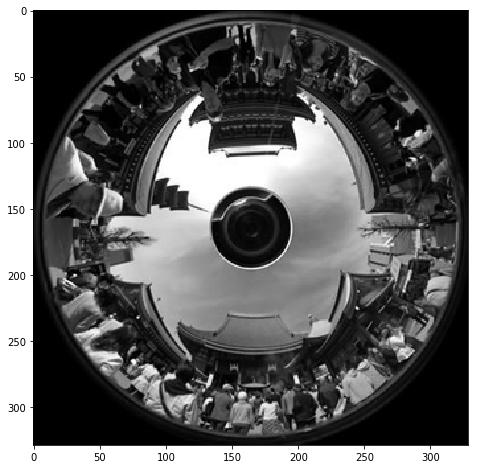

In [10]:
im, org = process('image2.png',30)
plt.imshow(org, cmap='gray');

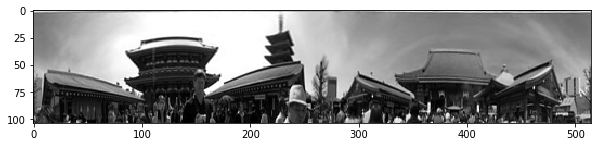

In [11]:
plt.imshow(im, cmap='gray');

Image size: 1414 1402
Parameters: center(x,y) 707,701 radius(max,min) 551,150
Unwrapped image size: 2202 401


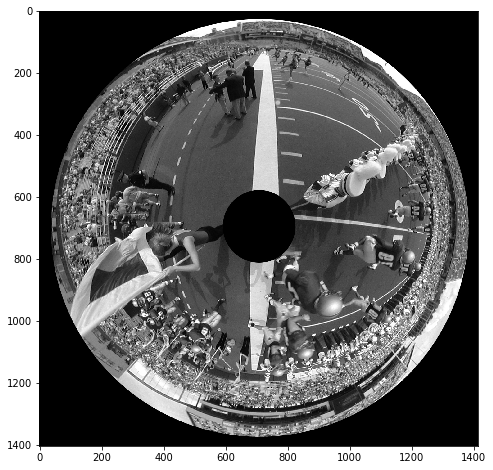

In [13]:
im, orig = process('football_donut.jpg', 150)
plt.imshow(orig, cmap='gray');

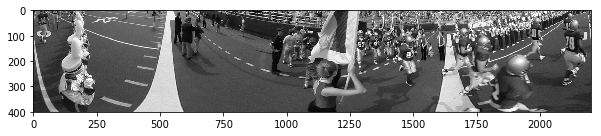

In [14]:
plt.imshow(cv2.flip(im,0), cmap='gray');

Notice in the bottom picture of times square, we are able to insert the advertisement onto the billboard by warping the image. With a little more programming and finess, you could start your own business selling advertisements to people on virtual billboards.

# Exercises

- Take a picture and try using one of the feature detectors discussed above on the image
- Try to recreate a virtual billboard on your own using different images

# Questions

1. What is a good feature?
1. What are the advantages and disadvantages of a catadioptric sensor?
1. What are the different feature detectors discussed here and what are their pros/cons?
1. What is homography?
1. What are some applications, beyond what we talked about, for homography?



-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.